### A simpler Titanic solution
- Feature engineering
- Data clean (wrangle)
- Loop through classifiers and compare

In [20]:
%matplotlib inline
import numpy as np
import pandas as pd
import re as re

train = pd.read_csv('train.csv', header = 0, dtype={'Age': np.float64})
test  = pd.read_csv('test.csv' , header = 0, dtype={'Age': np.float64})
full_data = [train, test]

print (train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


In [3]:
# preview data
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Feature Engineering
Check individual features, their importance, and engineer certain features

In [4]:
# 1. Pclass
print (train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean())

   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363


In [5]:
# 2. Sex
print (train[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean())

      Sex  Survived
0  female  0.742038
1    male  0.188908


In [6]:
# 3. Parch and SibSp, combine into FamilySize
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1   # families + the person
print (train[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean())

   FamilySize  Survived
0           1  0.303538
1           2  0.552795
2           3  0.578431
3           4  0.724138
4           5  0.200000
5           6  0.136364
6           7  0.333333
7           8  0.000000
8          11  0.000000


In [7]:
## Alone or not
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
print (train[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean())

   IsAlone  Survived
0        0  0.505650
1        1  0.303538


In [8]:
# 4. Embarked; fill missing value with the mode (most frequent)
freq_port = train.Embarked.dropna().mode()[0]
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna(freq_port)
    
train[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean()

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.339009


In [9]:
# 5. Fare; fill missing with the median, then categorize into 4 quantile_based catogories
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())

    # pd.qcut is for quantile-based discretization function
    train['CategoricalFare'] = pd.qcut(train['Fare'], 4)   
print (train[['CategoricalFare', 'Survived']].groupby(['CategoricalFare'], as_index=False).mean())

   CategoricalFare  Survived
0   (-0.001, 7.91]  0.197309
1   (7.91, 14.454]  0.303571
2   (14.454, 31.0]  0.454955
3  (31.0, 512.329]  0.581081


In [10]:
# 6. Age; fill missing with random values within mean+-std, then 5 range
for dataset in full_data:
    age_avg 	   = dataset['Age'].mean()
    age_std 	   = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
    
train['CategoricalAge'] = pd.cut(train['Age'], 5)   # cut into 5 range

print (train[['CategoricalAge', 'Survived']].groupby(['CategoricalAge'], as_index=False).mean())

  CategoricalAge  Survived
0  (-0.08, 16.0]  0.508772
1   (16.0, 32.0]  0.354260
2   (32.0, 48.0]  0.378486
3   (48.0, 64.0]  0.434783
4   (64.0, 80.0]  0.090909


C:\Users\DI\anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [11]:
# 7. Name, convert to title
def get_title(name):
	title_search = re.search(' ([A-Za-z]+)\.', name)
	# If the title exists, extract and return it.
	if title_search:
		return title_search.group(1)
	return ""

for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
    
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
 	'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

print (train[['Title', 'Survived']].groupby(['Title'], as_index=False).mean())

    Title  Survived
0  Master  0.575000
1    Miss  0.702703
2      Mr  0.156673
3     Mrs  0.793651
4    Rare  0.347826


### Data cleaning

In [12]:
for dataset in full_data:
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    
    # Mapping titles
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    
    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
    # Mapping Fare
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] 						        = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] 							        = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # Mapping Age
    dataset.loc[ dataset['Age'] <= 16, 'Age'] 					       = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age']                           = 4

# Feature Selection
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp',\
                 'Parch', 'FamilySize']
train = train.drop(drop_elements, axis = 1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)

test  = test.drop(drop_elements, axis = 1)

print (train.head(10))

train = train.values
test  = test.values

   Survived  Pclass  Sex  Age  Fare  Embarked  IsAlone  Title
0         0       3    1    1     0         0        0      1
1         1       1    0    2     3         1        0      3
2         1       3    0    1     1         0        1      2
3         1       1    0    2     3         0        0      3
4         0       3    1    2     1         0        1      1
5         0       3    1    1     1         2        1      1
6         0       1    1    3     3         0        1      1
7         0       3    1    0     2         0        0      4
8         1       3    0    1     1         0        0      3
9         1       2    0    0     2         1        0      3


### Compare Classifiers

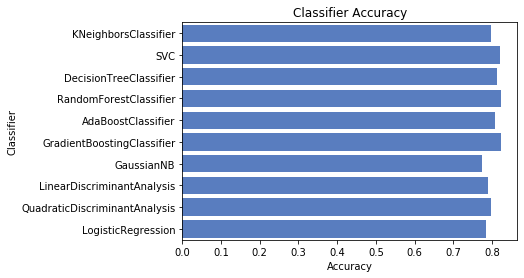

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedShuffleSplit   # creates splits by preserving the same percentage for each target class
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

# 10 classifiers
classifiers = [
    KNeighborsClassifier(3),
    SVC(probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
	AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    LogisticRegression()]

log_cols = ["Classifier", "Accuracy"]
log 	 = pd.DataFrame(columns=log_cols)

sss = StratifiedShuffleSplit(n_splits=10, test_size=0.1, random_state=0)

X = train[0::, 1::]
y = train[0::, 0]

acc_dict = {}

# split train into train and validation set
for train_index, test_index in sss.split(X, y):
	X_train, X_test = X[train_index], X[test_index]
	y_train, y_test = y[train_index], y[test_index]
	
	for clf in classifiers:
		name = clf.__class__.__name__
		clf.fit(X_train, y_train)
		train_predictions = clf.predict(X_test)
		acc = accuracy_score(y_test, train_predictions)
		if name in acc_dict:                             # for accumulating the 10 shuffled test sets 
			acc_dict[name] += acc
		else:
			acc_dict[name] = acc

for clf in acc_dict:
	acc_dict[clf] = acc_dict[clf] / 10.0
	log_entry = pd.DataFrame([[clf, acc_dict[clf]]], columns=log_cols)
	log = log.append(log_entry)

plt.xlabel('Accuracy')
plt.title('Classifier Accuracy')

sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=log, color="b")

In [15]:
log.sort_values(by='Accuracy', ascending=False)

,Classifier,Accuracy
0,GradientBoostingClassifier,0.824444
0,RandomForestClassifier,0.823333
0,SVC,0.822222
0,DecisionTreeClassifier,0.812222
0,AdaBoostClassifier,0.808889
0,QuadraticDiscriminantAnalysis,0.798889
0,KNeighborsClassifier,0.797778
0,LinearDiscriminantAnalysis,0.790000
0,LogisticRegression,0.784444
0,GaussianNB,0.775556


### Prediction
Use GradientBoosting

In [16]:
candidate_classifier = GradientBoostingClassifier()
candidate_classifier.fit(train[0::, 1::], train[0::, 0])
result = candidate_classifier.predict(test)

### Notes on Classifiers
- Ensemble Methods
    - Boosting
        - Base estimators (Decision Tree) are built sequentially and one tries to reduce the bias of the combined estimator.
        - **GradientBoosting**
            - Gradient Tree Boosting or Gradient Boosted Decision Trees (GBDT). Can be used for both regression and classification problems in a variety of areas including Web search ranking and ecology
            - Classifier: 
                - Params{n_estimator (~100, weak learners), learning_rate ([0,1]), max_depth, max_leaf_nodes (tree size)}
                - Use HistGradientBoostingClassifier for large number of classes
            - Regressor:
                - loss='ls' (least square)         
        - **AdaBoost**
            - A meta-estimator that begins by fitting a classifier on the original dataset and then fits additional copies of the classifier on the same dataset but where the weights of incorrectly classified instances are adjusted such that subsequent classifiers focus more on difficult cases.
            - Classifier:
                - Params {base estimator is DecisionTreeClassifier(max_depth=1), n_estimators, learning_rate}
            - Regressor:
                - loss=‘linear’, ‘square’, ‘exponential’ 
    - Averaging
        - **Bagging**
        - **RandomForest**
        
- Linear and Quadratic Discriminant Analysis
    - A linear and a quadratic decision surface. Closed-form solutions, inherently multiclass, no hyperparameters to tune.
    - **Linear Discriminant Analysis (LDA)**
        - Params {solver='svd','lsqr','eigen', shrinkage}
    - **Quadratic Discriminant Analysis (QDA)**
    